In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import RussianStemmer
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
def remove_tags(line):
    char_regex = re.compile(r'<[a-z]>')
    line = char_regex.sub(' ', str(line).lower())
    return line

In [10]:
def spell_check(line):
    char_regex = re.compile(r'[^а-я]')
    line = char_regex.sub(' ', line.lower())
    
    chkr_ru = SpellChecker(d_ru)
    chkr_ru.set_text(line)
    mistakes_ru = set([err.word for err in chkr_ru])
    
    
    tokenized = toktok.tokenize(line)
    num_mistakes=0
    for i in tokenized:
        if i in mistakes_ru:
            num_mistakes+=1
            
    num_words = len(line.split(' '))
    
    mistakes_rate = num_mistakes / num_words
            
    return mistakes_rate

In [3]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';')

In [4]:
data = pd.read_csv('employment_preprocessed.csv')

In [5]:
data.shape

(923643, 8)

In [14]:
# data.id.isna().sum()

In [15]:
data = data[data['id'].notnull()]

In [18]:
data.tail(2)

,id,position,employer,achievements,responsibilities,start_date,finish_date,text
892714,99998.0,Специалист по микрофинансовым операциям,"АО ""Вайнемейнен""",NaN,<ul><li>Оформление договоров займа</li><li>При...,2016-04-01,2020-03-01,оформлен договор займ при наличн формирован ар...
892715,99999.0,Секретарь,Департамент здравоохранения и социальной помощ...,NaN,"<ol><li>Ведения делопроизводства, выполнения п...",2006-06-01,2014-12-01,веден делопроизводств выполнен поручен руковод...


In [22]:
data['text'].isna().sum()

10301

In [23]:
data['text'].fillna('',inplace=True)

### Стат. признаки текста

In [7]:
# уберем только html тэги
data['resp_no_tags'] = data['responsibilities'].apply(remove_tags)

In [9]:
from string import punctuation

# длина комментария
data["answer_len"] = data['resp_no_tags'].apply(len)

# кол-во слов с заглавной буквы
data['upper_case_word_count'] = data['resp_no_tags'].apply(lambda x: len([wrd for wrd in x.split() if wrd[0].isupper()]))

# кол-во знаков препинания
data['punctuation_count'] = data['resp_no_tags'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation)))

In [ ]:
# Определим процент грамматических ошибок
import re
import pandas as pd
import enchant
from enchant.checker import SpellChecker
from nltk.tokenize import ToktokTokenizer

# инициализируем словари
d_ru = enchant.DictWithPWL('ru')

#инициализируем токенайзер
toktok = ToktokTokenizer()

data['resp_grammar_mistakes_per_cent'] = data['resp_no_tags'].apply(spell_check)

### Векторизация с Tf - idf

In [24]:
vect = TfidfVectorizer(ngram_range=(1,3), max_features=1000)
vect.fit(data['text'])

TfidfVectorizer(max_features=1000, ngram_range=(1, 3))

In [25]:
vectors = vect.transform(data['text'])

### clustering

In [30]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters
Fit 32 clusters
Fit 34 clusters
Fit 36 clusters
Fit 38 clusters
Fit 40 clusters
Fit 42 clusters
Fit 44 clusters
Fit 46 clusters
Fit 48 clusters
Fit 50 clusters


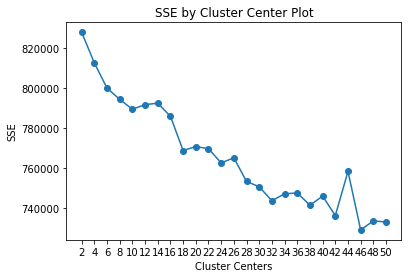

In [51]:
find_optimal_clusters(vectors, 50)

In [79]:
clusters = MiniBatchKMeans(n_clusters=50, init_size=1024, batch_size=2048, random_state=20).fit_predict(vectors)

In [80]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')

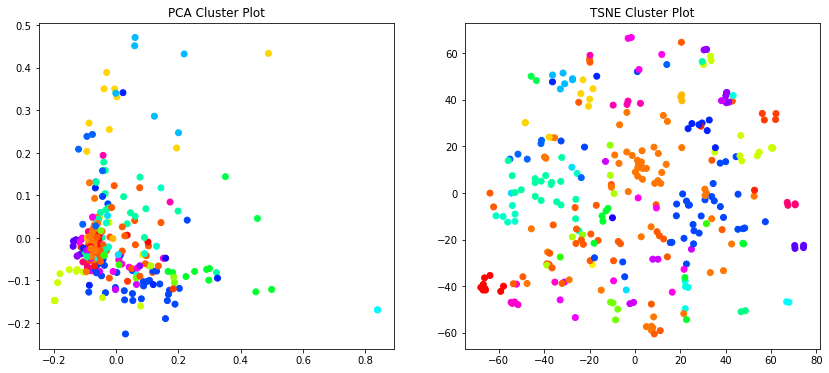

In [81]:
plot_tsne_pca(vectors, clusters)

In [82]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

In [83]:
get_top_keywords(vectors, clusters, vect.get_feature_names(), 10)


Cluster 0
веден,сдач,налогов,отчетн,учет,начислен,расчет,заработн плат,заработн,плат

Cluster 1
установк,эксплуатац,газов,работ,установок,оператор,ремонт,обслуживан,оборудован,котельн

Cluster 2
установк,обслуживан,работ,трубопровод,конструкц,ремонт,сист,оборудован,демонтаж,монтаж

Cluster 3
при,водител,проведен,оформлен,подготовк,составлен,документац,документ,веден,работ

Cluster 4
сопровожден,рабоч,оборудован,выполнен,обеспечен,производств,руководств,уход,издел,обязан

Cluster 5
водител,при,руководств,работ,гсм,тмц,организац,подрядн,подрядн организац,склад

Cluster 6
издел,гост,соблюден,технологическ,согласн,продукт,карт,холодн,блюд,приготовлен

Cluster 7
магазин,склад,работ,при,консультирован,консультац,покупател,продаж товар,продаж,товар

Cluster 8
контрол,составлен,товар,проведен,при,документац работ,работ,веден,документац,веден документац

Cluster 9
продаж,обеспечен,работ работ,сбор,обслуживан,приемк,проведен,оформлен,документ,работ

Cluster 10
техническ,техник,ремонт оборудован

In [88]:
data['cluster'] = clusters

In [144]:
train_salary_cluster = pd.merge(train[['id', 'salary']], data, on='id')
test_salary_cluster = pd.merge(test[['id']], data, on='id')

In [145]:
train.shape, train_salary_cluster.shape

((306270, 25), (625430, 10))

In [146]:
test.shape, test_salary_cluster.shape

((131259, 24), (267286, 9))

In [147]:
# посмотрим на данные

In [148]:
train_salary_cluster[train_salary_cluster.cluster==33]

,id,salary,position,employer,achievements,responsibilities,start_date,finish_date,text,cluster
10812,7166,27749,Ассистент,Костромской государственный университет,NaN,<p>Организация образовательного процесса (преп...,2017-09-01,NaN,организац образовательн процесс преподаван дис...,33
103704,71853,19905,преподаватель,Вельский экономический техникум,NaN,"<p>Преподавание дисциплины ""Информационные тех...",1993-10-01,2008-10-01,преподаван дисциплин информацион технолог студ...,33
111475,77235,30000,Преподаватель информатики,"ГПОУ ""Кемеровский техникум индустрии питания и...",NaN,<p>обучение студентов по дисциплине Информатик...,2020-04-01,2020-07-01,обучен студент дисциплин информатик информацио...,33
111476,77235,30000,Преподаватель информатики,"ГПОУ ""Кемеровский педагогический колледж""",NaN,<p>обучение студентов по дисциплине Информатик...,2008-10-01,2020-02-01,обучен студент дисциплин информатик информацио...,33
167622,116656,28878,преподаватель,"ФГБОУ ВПО ""УдГУ""",NaN,<p>преподавание по образовательным программам ...,2017-09-01,NaN,преподаван образовательн программ высш професс...,33
172550,120175,100000,Помощник ректора по административно-хозяйствен...,Коми республиканская академия государственной ...,NaN,<p>Реализация образовательных программ высшего...,2002-08-01,2002-12-01,реализац образовательн программ высш профессио...,33
172551,120175,100000,Помощник ректора по административно-хозяйствен...,Республиканская академия госслужбы и управления,NaN,<p>Реализация образовательных программ высшего...,2002-12-01,2006-02-01,реализац образовательн программ высш профессио...,33
348577,243840,24065,старший лаборант,Поволжская академия государственной службы им....,NaN,<p>Работа со студентами в Деканате факультета ...,2007-11-01,2008-05-01,работ студент деканат факультет втор высш проф...,33
572113,400023,41520,"ассистент, кафедра основ архитектуры","ФГБОУ ВО ""Государственный университет по земле...",NaN,"<p>Преподавание дисциплин ""Архитектурное проек...",2015-09-01,NaN,преподаван дисциплин архитектурн проектирован ...,33
593713,415391,22289,Координатор образовательного проекта в рамках ...,Государственный университет управления,<p>Представила проект в международном конкурсе...,<p>Придумала и реализовала профессиональный об...,2015-09-01,2015-12-01,придума реализова профессиональн образовательн...,33


In [149]:
test_salary_cluster[test_salary_cluster.cluster==33]

,id,position,employer,achievements,responsibilities,start_date,finish_date,text,cluster
59325,97586,мастер производственного обучения,профессиональное училище № 84,NaN,<p>Обучение студентов основам технологии прода...,2002-01-01,2005-09-01,обучен студент основ технолог продаж,33
65003,106946,ассистент кафедры дошкольной педагогики и детс...,Орский педагогический институт,NaN,<p>Преподавание методики музыки для студентов ...,1994-09-01,1996-10-01,преподаван методик музык студент дошкольн факу...,33
79090,130202,директор Череповецкого филиала,"НОУ ВПО ""Университет российской академии образ...",<p>благодарность Государственной Думы ФС РФ</p>,<p>руководитель образовательной организации вы...,2012-12-01,2016-10-01,руководител образовательн организац высш профе...,33
122363,200234,практикант декоратор,Театр Юного Зрителя,NaN,"<p>Будучи студентом, проходила несколько раз п...",2018-04-01,2019-07-01,будуч студент проход нескольк практик тюз весн...,33
200324,327584,Преподаватель,ГБОУ НСО НТК,"<p>Курсы повышения квалификации, 1 квалификаци...","<p>Обучение студентов по дисциплине ""Информати...",2016-04-01,NaN,обучен студент дисциплин информатик информацио...,33
253649,415447,Инженер-химик,Саратовский Государственный Университет им.Н.Г...,NaN,"<p style=""text-align: left,""><em>практика со с...",2009-09-01,2011-10-01,практик студент,33


In [150]:
# теперь агрегируем среднюю, макс, мин зп по кластеру

from functools import reduce

def aggregate(data):

    mean_df = data.groupby(['cluster'], as_index=False).agg(np.mean)
    mean_df.columns = [str(col) + '_mean' if col != 'cluster' else 'cluster' for col in mean_df.columns]
    
    max_df = data.groupby(['cluster'], as_index=False).agg(np.max)
    max_df.columns = [str(col) + '_max' if col != 'cluster' else 'cluster' for col in max_df.columns]
    
    min_df = data.groupby(['cluster'], as_index=False).agg(np.min)
    min_df.columns = [str(col) + '_min' if col != 'cluster' else 'cluster' for col in min_df.columns]
    
    data_frames = [mean_df, max_df, min_df]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['cluster'], how='right'), data_frames)
    return df_merged

In [151]:
salary_by_cluster = aggregate(train_salary_cluster[['cluster', 'salary']])

In [152]:
salary_by_cluster.shape

(50, 4)

In [153]:
train_salary_cluster.shape

(625430, 10)

In [154]:
train_salary_cluster_agg = pd.merge(salary_by_cluster, train_salary_cluster)
train_salary_cluster_agg.head(15)

,cluster,salary_mean,salary_max,salary_min,id,salary,position,employer,achievements,responsibilities,start_date,finish_date,text
0,0,44833.370096,2200039,0,40,50000,бухгалтер,"ООО ""ТИС""",NaN,<ul><li>Ведение бухгалтерского и налогового уч...,2017-10-01,2018-01-01,веден бухгалтерск налогов учет осн услуг расче...
1,0,44833.370096,2200039,0,40,50000,Генеральный директор(главный бухгалтер),"ООО ""ПесКарь""",NaN,<ul><li>Ведение бухгалтерского и налогового уч...,2016-07-01,2017-10-01,веден бухгалтерск налогов учет полн объем осн ...
2,0,44833.370096,2200039,0,40,50000,Главный бухгалтер,"ООО ""СК Алесио""",NaN,<ul><li>Ведение бухгалтерского и налогового уч...,2004-01-01,2012-04-01,веден бухгалтерск налогов учет полн объем осн ...
3,0,44833.370096,2200039,0,40,50000,зам.главного бухгалтера,"ООО ""АкваТехСервис""",NaN,<ul><li>Ведение бухгалтерского и налогового уч...,2012-07-01,2015-03-01,веден бухгалтерск налогов учет полн объем енвд...
4,0,44833.370096,2200039,0,40,50000,зам.главного бухгалтера,"ООО ""МЖСтрой""",NaN,<ul><li>Ведение бухгалтерского и налогового уч...,2015-03-01,2016-06-01,веден бухгалтерск налогов учет полн объем осн ...
5,0,44833.370096,2200039,0,40,50000,заместитель главного бухгалтера,"ООО ""КРАФТ""",NaN,<ul><li>Ведение бухгалтерского и налогового уч...,2018-02-01,2020-05-01,веден бухгалтерск налогов учет полн объем усн ...
6,0,44833.370096,2200039,0,44,55200,Инженер отдела защиты объемов и договоров ТЭР,"ГУП ""ЖКХ РС(Я)""",NaN,<p>Расчет потерь в теплосетях</p>,2003-09-01,2005-02-01,расчет потер теплосет
7,0,44833.370096,2200039,0,194,22836,Бухгалтер,"ООО ""Кубань-Баланс""",NaN,"<p>Консультирование, работа в 1С 8.3 (банк, ка...",2015-11-01,2019-05-01,консультирован работ банк касс накладн авансов...
8,0,44833.370096,2200039,0,194,22836,Бухгалтер,"ООО "" Баланс""",NaN,"<p>Ведение ИП (аутсорсинг), формирование отчет...",2011-02-01,2014-06-01,веден ип аутсорсинг формирован отчетн акт счет...
9,0,44833.370096,2200039,0,236,36330,Бухгалтер,"ТСЖ ""ИНТЕР""",NaN,"Расчёт заработной платы, отчисление налогов, о...",2015-09-01,2016-01-01,расч т заработн плат отчислен налог обработк п...


In [155]:
test_salary_cluster_agg = pd.merge(salary_by_cluster, test_salary_cluster)
# test_salary_cluster[test_salary_cluster.cluster==6]

In [158]:
test_salary_cluster[test_salary_cluster.cluster==8]

,id,position,employer,achievements,responsibilities,start_date,finish_date,text,cluster
154,250,Старший продавец,ООО МОЙДОДЫР КУРСК,NaN,"<p><span style=""text-decoration: underline,""><...",2016-03-01,2020-07-01,при выкладк реализац товар веден документац,8
251,402,Начальник станции 3 класса,"Филиал АО ""НК ""КТЖ""-""Павлодарское отделение до...",NaN,<p>Руководство работой железнодорожной станции...,2012-12-01,2015-03-01,руководств работ железнодорожн станц веден док...,8
252,402,Исполняющий обязанности начальника станции,"Филиал АО ""НК ""КТЖ""-""Павлодарское отделение до...",NaN,<p>Руководство работой железнодорожной станции...,2012-02-01,2012-12-01,руководств работ железнодорожн станц веден док...,8
253,402,инженер по охране труда и технике безопасности,ГКП на ПХВ Теплосервис,NaN,<p>Контроль соблюдения ОХТ и ТБ на предприятии...,2008-12-01,2009-09-01,контрол соблюден охт тб предприят внесен предл...,8
270,442,Водитель - экспедитор,"ООО""ЙОНАС СПБ""",NaN,<p>Развозка продукции по продуктовым магазинам...,2019-09-01,2020-02-01,развозк продукц продуктов магазин веден докуме...,8
...,...,...,...,...,...,...,...,...,...
265801,435175,Бухгалтер,ООО империя,NaN,<p>Ведение документации</p>,2017-05-01,2018-03-01,веден документац,8
265810,435188,Руководитель технической службы,ООО НОВГОРОДСКИЙ БЕКОН,<p>Повышение в должности</p>,"<p>Ведение документации, контроль исполнения р...",2019-09-01,2020-04-01,веден документац контрол исполнен работ предпр...,8
266626,436506,кредитный экспер,"ЗАО ""БНП ПАРИБА Банк""",NaN,"<p>работа по привлеченю клиентов, формление до...",2010-05-01,2012-07-01,работ привлечен клиент формлен договор веден д...,8
266628,436506,старший специалист по привлечению клиентов,"оао банк ""Открытие""",NaN,"<p>работа по привлеченю клиентов, формление до...",2012-11-01,2015-01-01,работ привлечен клиент формлен договор веден д...,8


In [159]:
# у одного id может быть несколько кластеров в зависимости от опыта работы (несколько строк в employments_mult.csv)
# оставим только наиболее частый кластер для этого id и соответствую кластеру среднюю, мин, макс зп

In [173]:
ids_with_cluster = train_salary_cluster_agg.groupby(['id'], as_index=False)['cluster'].agg(pd.Series.mode)['id']

test_ids_with_cluster = test_salary_cluster_agg.groupby(['id'], as_index=False)['cluster'].agg(pd.Series.mode)['id']

In [169]:
tr_mode_cluster = train_salary_cluster_agg.groupby(['id'], as_index=False).agg(
                                cluster_mode  = ('cluster', lambda x: x.value_counts().index[0])
                                      )

In [170]:
tr_mode_cluster['id'] = ids_with_cluster

In [175]:
test_mode_cluster = test_salary_cluster_agg.groupby(['id'], as_index=False).agg(
                                cluster_mode  = ('cluster', lambda x: x.value_counts().index[0])
                                      )

In [176]:
test_mode_cluster['id'] =  test_ids_with_cluster

In [177]:
tr_mode_cluster.shape, test_mode_cluster.shape

((240443, 2), (102912, 2))

In [180]:
tr_mode_cluster.columns = ['cluster', 'id']
test_mode_cluster.columns = ['cluster', 'id']

In [185]:
# возьмем соответствую кластеру среднюю, мин, макс зп

tr_sal = pd.merge(salary_by_cluster, tr_mode_cluster)
test_sal = pd.merge(salary_by_cluster, test_mode_cluster)

# pd.merge(salary_by_cluster, test_mode_cluster)

In [191]:
train_v8 = pd.read_csv('train_v8.csv')
test_v8 = pd.read_csv('test_v8.csv')

In [192]:
train_v8.shape, test_v8.shape, tr_sal.shape, test_sal.shape

((306270, 122), (131259, 121), (240443, 5), (102912, 5))

In [198]:
final_train = pd.merge(train_v8, tr_sal, how='left',on='id')

In [199]:
final_test = pd.merge(test_v8, test_sal, how='left', on='id')

In [209]:
for i in final_train[['salary_mean','salary_max', 'salary_min']].columns:
    final_train[i].fillna(final_train[i].median(), inplace=True)

In [210]:
for i in final_test[['salary_mean','salary_max', 'salary_min']].columns:
    final_test[i].fillna(final_test[i].median(), inplace=True)

In [211]:
final_train['cluster'].fillna(50, inplace=True)
final_test['cluster'].fillna(50, inplace=True)

In [212]:
final_train.isna().sum()

id                               0
grammar_mistakes_per_cent        0
Avr2019                      50845
Avr2020                      50845
create_year                      7
                             ...  
completeness_rate                0
cluster                          0
salary_mean                      0
salary_max                       0
salary_min                       0
Length: 126, dtype: int64

In [213]:
final_train.to_csv('train_v10.csv',index=False)
final_test.to_csv('test_v10.csv',index=False)